Pipelines: Mass Total + Source Parametric
=========================================

By chaining together two searches this script fits strong lens `Imaging`, where in the final model:

 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllIsothermal`.
 - The source galaxy's light is a bulge+disk parametric `EllSersic`'s.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

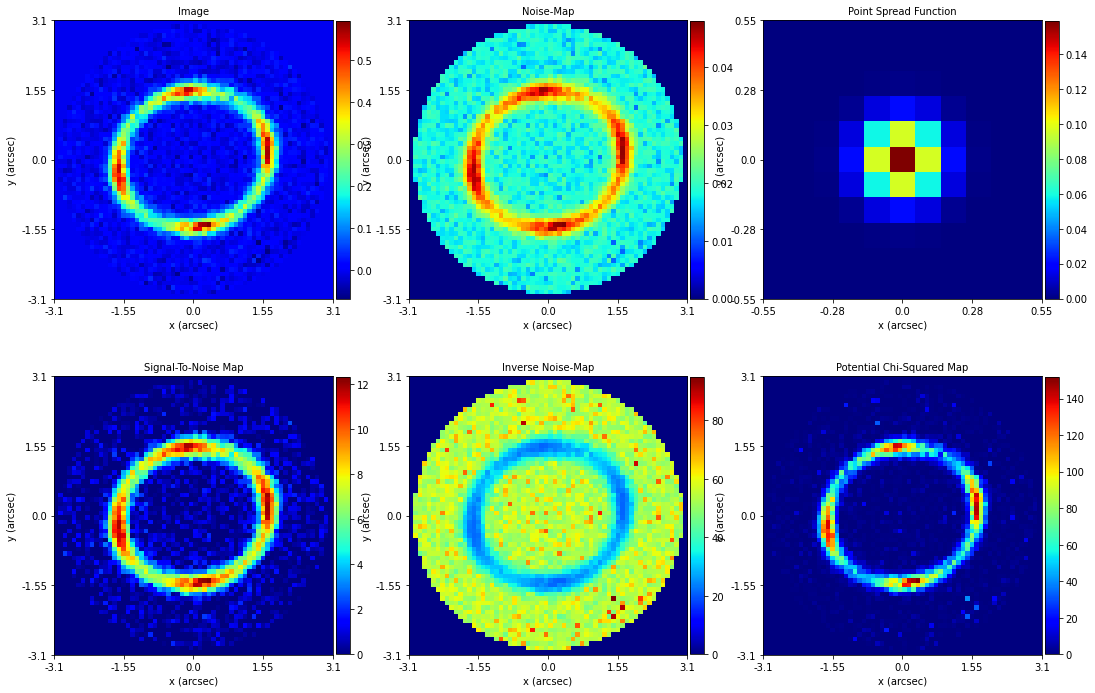

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "pipelines", dataset_name)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal, shear=al.mp.ExternalShear
        ),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[1]_mass[sie]_source[parametric]",
    n_live_points=50,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 11.32it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is an `EllPowerLaw` with `ExternalShear` [8 parameters: priors 
 initialized from search 1].
 
 - The source galaxy's light is a bulge+disk using two parametric `EllSersic`'s whose centres are shared
 [12 parameters: priors of bulge initialized from search 1].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=20.

In [6]:
mass = af.Model(al.mp.EllPowerLaw)
mass.take_attributes(result_1.model.galaxies.lens.mass)

bulge = result_1.model.galaxies.source.bulge
disk = af.Model(al.lp.EllSersic)

bulge.centre = disk.centre

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy, redshift=0.5, mass=mass, shear=result_1.model.galaxies.lens.shear
        ),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=bulge, disk=disk),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_mass[total]_source[parametric]",
    n_live_points=100,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 99.11it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.